In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np


Best coefficients from GA: [2.20104273 0.61663015 3.81951573 2.59115492]
Best coefficients from np.polyfit(): [ 1.97603614 14.65882083  6.01454058 40.44610037]


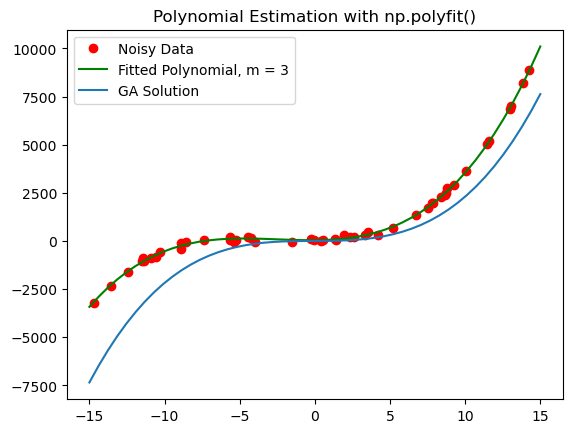

Polyfit RMSE = 86.22726782641027
Genetic algorithm RMSE = 4210.341387876641


In [18]:

def crossover_event(parent1, parent2, crossover_rate):
    if random.random() < crossover_rate:
        # Select two random crossover points
        xover1 = random.randint(0, len(parent1) - 1)
        xover2 = random.randint(xover1, len(parent1))
        # Perform the two-point crossover to get offspring
        xover_slice = parent1[xover1:xover2]
        parent1[xover1:xover2] = parent2[xover1:xover2]
        parent2[xover1:xover2] = xover_slice
        
    return [parent1, parent2]

def mutation_event(mutation_chance, mutation_rate):
    children = []
    for chance,child in mutation_chance:
        if chance < mutation_rate:
            # if random chance is less than mutation rate
            index1, index2 = random.sample(range(len(child)), 2)
            val1, val2 = child[index1], child[index2]
            # switch two random "alleles"
            child[index1] = val2
            child[index2] = val1
        # append mutated children, or same children if chance > mutation_rate
        children.append(child)
    return children[0],children[1]

def generate_population(size, poly_degree):
    '''return population of random polynomial weights''' 
    return np.random.uniform(-10, 10, (size, poly_degree + 1))

def fitness_eval(coeff, x, y):
    '''evaluate prediction mse and return mse*-1 to maximize fitness'''
    y_pred = np.polyval(coeff, x)
    return -np.mean(np.square(y - y_pred))

def genetic_algorithm(x, y, poly_degree, population_size = 100, 
                      crossover_rate = 0.8, mutation_rate = 0.01, generations=1000):
    
    # population of random weights [cn,...,c1,c0], where n=poly_degree; y = cn*x^n+...+c1*x^1+c0
    population = generate_population(population_size, poly_degree)

    for _ in range(generations):
        # split population into consecutive mating pairs
        mating_pairs = np.array_split(population, population_size/2)
        next_gen = []
        # perform two-point crossover and/or mutation and generate children
        for parent1,parent2 in mating_pairs:
            children = crossover_event(parent1, parent2, crossover_rate)
            # zip children with mutation chance and return resulting children
            mutation_chance = [round(random.uniform(0, 1), 3), round(random.uniform(0, 1), 3)]
            mutation_chance = list(zip(mutation_chance,children))
            child1, child2 = mutation_event(mutation_chance, mutation_rate)
            # add children to next generation
            next_gen.append(child1)
            next_gen.append(child2)
        # reset population using children
        population = np.array(next_gen)
    # find coeffs with lowest MSE
    best_individual = max(population, key=lambda coeff: fitness_eval(coeff, x, y))
    return best_individual

### initialize data set
n_samples = 50
noise_scale = 100

x = 30*(np.random.rand(n_samples, 1) - 0.5)
y = 5 * x + 15 * x**2 + 2 * x**3 + noise_scale*np.random.randn(n_samples, 1)

# Fit the polynomial using the genetic algorithm
m = 3
best_weights = genetic_algorithm(x, y, m)
print(f'Best coefficients from GA: {best_weights}')
# print("Genetic algorithm MSE:", best_mse)

x,y = x.reshape(n_samples,), y.reshape(n_samples,)

# fit a polynomial of degree m to the noisy data (x,y) and reformat to use as a transformer
poly = np.poly1d(np.polyfit(x,y,m))
print(f'Best coefficients from np.polyfit(): {poly.coefficients}')

# create a test dataset by sampling points along the x-axis
t = np.linspace(-15,15,n_samples)
y_pred = np.polyval(best_weights, t)

# apply the fitted polynomial to the test set and plot over the noisy data
plt.plot(x,y,'ro', label = "Noisy Data")
plt.plot(t, poly(t), 'g-', label = "Fitted Polynomial, m = "+str(m))
plt.plot(t, y_pred, label='GA Solution')

plt.legend()
plt.title("Polynomial Estimation with np.polyfit()")

plt.show()

MSE_noise = np.sum([(i-j)**2 for i,j in zip(poly(x),y)])/n_samples
MSE_ga = np.sum([(i-j)**2 for i,j in zip(y_pred,y)])/n_samples

print("Polyfit RMSE = "+str(np.sqrt(MSE_noise)))
print("Genetic algorithm RMSE = "+str(np.sqrt(MSE_ga)))

## Performance

The np.polyfit() method had a significantly lower RMSE than the genetic algorithm (GA) method, indicating it was a better fit for the data, shown in the graph above. This is because polyfit assumes linearity, unlike GA's that mimic biological "search" methods and introduce more randomness than polyfit.

GA's are more widely applicable to almost any type of data, but are slower on simple models like a 3rd degree polynomial. Given more iterations or trying different crossover or mutation methods, as well as testing different mutation and crossover rates, can help improve GA performance.